Name: Josemaria Macedo Carrillo\
Ttile: Land Matrix Data Exploration\
Created: 08/07/23\
Last modified:
DSI

The purpose of this notebook is to analyze data on Ukrainian agricultural
exports for October 2022 (busiest month according to BSGI). The main data sources
are the Black Sea Grain Initiative (BSGI) of the United
Nations and Import Genius (IG), a website that has trade data for different countries
including Ukraine.

In [1]:
import sys
sys.path.append('..')
import pandas as pd
from utils.get_data import get_data
from utils.record_linkage import rl_ig_bsgi
from utils.plot import cargo_grouping, plot_line, plot_crops, plot_pie
from utils.clean_data import PRODUCTS_VAL, translate_column
from utils.transform_data import estimate_weights
from utils.record_linkage import record_linkage, unique_matches, filter_crop
import matplotlib.pyplot as plt

Import cleaned data from Import Genius (IG) and the Black Sea Grain Initiative
(BSGI) with all the necessary columns for further analysis.

In [2]:
ig = get_data("ig")
bsgi = get_data("bsgi")

In [3]:
ig_oct = ig.loc[(ig.loc[:, "date"] >= "2022-10-01") & (ig.loc[:, "date"] < "2022-11-01")]
bsgi_oct = bsgi.loc[(bsgi.loc[:, "date"] >= "2022-10-01") & (bsgi.loc[:, "date"] < "2022-11-01")]

We group our data to plot a time series for Kernel, one of the top 10 Ukrainian
agricultural landholders with data from IG. The data is just for October 2022
because it was the most we could export for now with our
subscription and that month was the busiest exports month according to BSGI.
The horizontal axis has the export date in mm-yyyy and the
vertical axis has the total exports volume in metric tons (1,000 kilograms).

We see that there is a shift in the trend of exports in February 2022, when
Russia invaded Ukraine. This makes sense because all Black Sea ports that these
agricultural companies used where closed until the BSGI was signed in July 27,
2022. We can see there was an increase in exports but not as much as in the past.
This could be due to the lack of ports to export (only 3 ports can export at
the Black Sea and a lot of companies have to use the same ports).

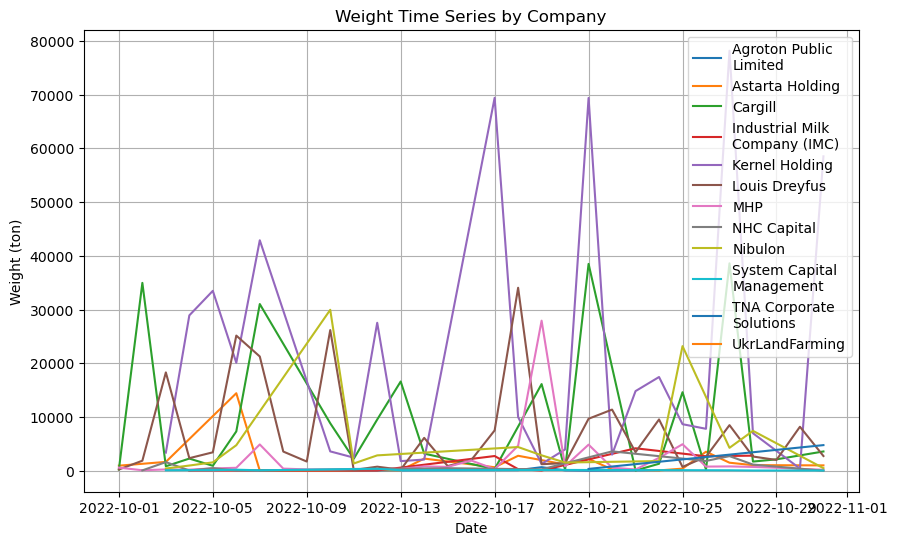

In [4]:
ig_oct_g = cargo_grouping(ig_oct, ["parent_company", "date"], ["weight_ton"], ["date"], True, {"weight_ton": "sum"})
ig_oct_g

# Group by "company_searched"
grouped = ig_oct_g.groupby('parent_company')

# Plot each group as a separate line
plt.figure(figsize=(10, 6))

for name, group in grouped:
    plt.plot(group['date'], group['weight_ton'], label=name)

plt.xlabel('Date')
plt.ylabel('Weight (ton)')
plt.title('Weight Time Series by Company')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

In [5]:
ig_oct.loc[(ig_oct.loc[:, "company_searched"] == "kernel") & (ig_oct.loc[:, "country"] == "німеччина")][["product", "company_searched", "date", "weight_ton", "country"]]
# oct.loc[(oct.loc[:, "company_searched"] == "kernel")][["product", "company_searched", "date", "weight_ton", "country"]]

,product,company_searched,date,weight_ton,country
2170,кукурудза: - інша,kernel,2022-10-17,909.0,німеччина


In [6]:
bsgi.loc[(bsgi.loc[:, "country_en"] == "germany") & (bsgi.loc[:, "date"] >= "2022-10-01") & (bsgi.loc[:, "date"] < "2022-11-01")][["product", "date", "weight_ton", "country_en"]]
# bsgi.columns

,product,date,weight_ton,country_en
673,corn,2022-10-31,49000,germany
776,rapeseed,2022-10-13,30817,germany
844,corn,2022-10-04,38000,germany


In [7]:
ig_sunflower = filter_crop(ig_oct, "sunflower", "ig")
bsgi_sunflower = filter_crop(bsgi_oct, "sunflower", "bsgi")
ig_sunflower_g = cargo_grouping(ig_sunflower, ["date", "country", "company_searched"], ["weight_ton"],  ["date", "country"], True, {"weight_ton":"sum"})
ig_sunflower_g.sort_values(by=["date"], ascending=True).head(50)[["company_searched", "date", "weight_ton", "country"]]
ig_sunflower_g["weight_ton"].sum()

213307.00741999998

In [8]:
bsgi_sunflower.sort_values(by=["date"], ascending=True)[["product", "date", "weight_ton", "country_en", "departure_port"]]
bsgi_sunflower["weight_ton"].sum()

610934

We estimate the shares of total exports by company.

bsgi_weight:  4241809
ig_weight:  1191434.89292


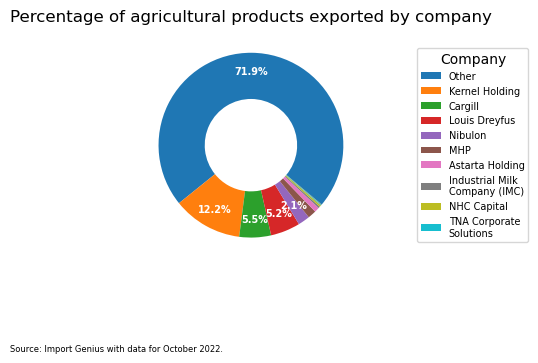

In [17]:
# ADD THIS TO ESTIMATE WEIGHTS FUNCTION

ig_oct_g = cargo_grouping(ig_oct, ["parent_company"], ["weight_ton"], ["parent_company"], True, {"weight_ton": "sum"})
ig_oct_g

bsgi_weight = bsgi_oct["weight_ton"].sum()
print("bsgi_weight: ", bsgi_weight)
ig_weight = ig_oct_g["weight_ton"].sum()
print("ig_weight: ", ig_weight)
other = bsgi_weight - ig_weight

bsgi_dict = {'parent_company': 'Other', 'weight_ton': [other]}
bsgi_dict
bsgi_df = pd.DataFrame(bsgi_dict)
final = pd.concat([ig_oct_g, bsgi_df], ignore_index=True)
final = final.sort_values(by=["weight_ton"], ascending=False)
final

plot_pie(final["parent_company"], final["weight_ton"], "Company", "Percentage of agricultural commodities exported by company", "Import Genius with data for October 2022", 2, 0.1)


We estimate the shares of sunflower exports by company.

In [10]:
ig_sunflower = filter_crop(ig_oct, "sunflower", "ig")
ig_oct_g = cargo_grouping(ig_sunflower, ["parent_company"], ["weight_ton"], ["parent_company"], True, {"weight_ton": "sum"})

bsgi_weight = filter_crop(bsgi_oct, "sunflower", "bsgi")["weight_ton"].sum()
ig_weight = ig_oct_g["weight_ton"].sum()
other = bsgi_weight - ig_weight

bsgi_dict = {'parent_company': 'other', 'weight_ton': [other]}
bsgi_df = pd.DataFrame(bsgi_dict)
final = pd.concat([ig_oct_g, bsgi_df], ignore_index=True)
final = final.sort_values(by=["weight_ton"])

plot_pie(final["parent_company"], final["weight_ton"], "Parent company", "Sunflower volume (metric tons) exported by parent company")

TypeError: plot_pie() missing 1 required positional argument: 'data_source'

In [ ]:
ig_oct["weight_ton"]

0    5314.350
1    5036.250
2    1039.800
3    1449.200
4    6510.788
       ...   
3      25.610
4      24.720
5      25.640
6      24.820
7      25.460
Name: weight_ton, Length: 2561, dtype: float64